# Demonstration Notebook: LDA Visualization

## Imports and Setup

We first need to import the packages that we are going to for loading, processing and analysing the data.

In [12]:
# the data is stored in a json file, so we use Python's json package to read it
import json

# regex
import re

# spacy is used for preprocessing
import spacy

# gensim is used to train a topic model
from gensim import models, corpora
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, strip_tags, strip_punctuation, strip_numeric
from gensim.models import CoherenceModel

# pyLDAvis used for the visualisation
import pyLDAvis
import pyLDAvis.gensim_models as pylda_gensimvis

# a progress bar is really helpful
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# also set up logging output
import logging
logging.basicConfig(format="%(asctime)s %(message)s", level=logging.INFO)

import pathlib

logger = logging.getLogger(__name__)

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data Loading

We first load the data from the JSON file. For this experiment, we are only interested in the lyrics and discard all the metadata.

In [2]:
# load data
path_to_corpus = "../data/rebetiko_corpus.json"
output_path = "../outputs/plots/"

output_path = pathlib.Path(output_path)
output_path.mkdir(exist_ok=True, parents=True)

with open(path_to_corpus) as f:
    corpus_data = json.load(f)

corpus_data = corpus_data["RECORDS"]

list_of_songs = []

for song in corpus_data:
    if song["lyrics"] is None:
        continue
    lyrics = song["lyrics"]
    lyrics = lyrics.replace("\n", " ")
    lyrics = re.sub(' +', ' ', lyrics)
    list_of_songs.append(lyrics.lower())

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocess Data


For data preprocessing, we use spacy. First we load a language model. The processing pipeline consists of tokenization, tagging, parsing, named entity recognition and lemmatization. In addition, we add a component that removes stopwords.

In [3]:
# load the spacy language model for the Greek language
nlp = spacy.load("el_core_news_lg")

# Get default stop words from spacy
default_stop_words = nlp.Defaults.stop_words

# Define additional stop words
additional_stopwords = ["μου","σου","σ\'","κι","απ\'","μ\'", "\'μ\'", "ν\'","του","σ", "γι\'", "δώσ\'",
"θά","μες","σαι","βρεις", "-","σένανε" ,"διάφορα","σύνθημα", "βλέπω","δεις", "\'ρθει", "κάν\'", "λεν\'", "σέ","τήν",
"πάω","τ","μ","εσύ","εσυ","νά","\'χα","την","και","τη","είπες", "ς","μια","συ", "\'συ", "τ\'", "είν\'", "γιά", "καί",
"ένα","τι","της","σένα","λες","\'χεις","πες","κάνω","κάνει","κάνεις","έχεις", "έχω","\'χω","στ\'", "είδ\'", "τόν", "μέ",
"π\'","θε","θες","μες","είδα","είδες","πήρες","βρω","ναι","είν","λέω","πεις", "απ","δως","τ", "\'χε", "\'ναι", "μεσ\'",
"ρθω","πάρει","σα","ε","ξέρεις","ξέρω","δω","άλλονε","ό","θ\'","έκανες", "πάει", "έχε", "είμ\'", "τό", "μπορώ",
"θέλει","ποιος","πει","\'γω","ρθει","πάρε","πάρω","μπορώ","πας","λες","λένε", "λενε", "πάν\'", "\'χει",
"βρήκα","καμιά","μένα","κάνε","γίνω","λέγω","έλεγα","είπα","τί","τι","\'πα", "βρω", "\'ν"]

# Add them to spacy's list of stop words
nlp.Defaults.stop_words.update(additional_stopwords)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in additional_stopwords:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

docs = nlp.pipe(list_of_songs)

# process the corpus; the result is a list of lists of strings (i.e. a list of songs)
lyrics_for_lda = []

for doc in docs:
    lyrics_list = []

    tokens_filtered = [token.text for token in doc if not token.is_stop and token.is_alpha]
    lyrics_for_lda.append(tokens_filtered)

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model Training

Now we can train a topic model via our preprocessed data. Here we train a Latent Dirichlet Allocation (LDA) model with the help of the gensim library.

In [4]:
# create a dictionary representation of the documents
dictionary = corpora.Dictionary(lyrics_for_lda)

# filter words from the dictionary that are very rare or occur very often
dictionary.filter_extremes(no_below=3, no_above=0.6)

# compute a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in lyrics_for_lda]

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-02-23 22:17:06,292 adding document #0 to Dictionary(0 unique tokens: [])
2022-02-23 22:17:06,398 built Dictionary(17830 unique tokens: ['άιντε', 'άφηνα', 'έμαθα', 'έξυπνα', 'έπινα']...) from 5097 documents (total 169239 corpus positions)
2022-02-23 22:17:06,424 Dictionary lifecycle event {'msg': "built Dictionary(17830 unique tokens: ['άιντε', 'άφηνα', 'έμαθα', 'έξυπνα', 'έπινα']...) from 5097 documents (total 169239 corpus positions)", 'datetime': '2022-02-23T22:17:06.398604', 'gensim': '4.0.1', 'python': '3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:50:57) \n[Clang 11.0.1 ]', 'platform': 'macOS

In [5]:
# now we can train a topic model
model = models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15,eval_every=None)

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-02-23 22:17:06,486 using symmetric alpha at 0.2
2022-02-23 22:17:06,487 using symmetric eta at 0.2
2022-02-23 22:17:06,487 using serial LDA version on this node
2022-02-23 22:17:06,490 running online (multi-pass) LDA training, 5 topics, 15 passes over the supplied corpus of 5097 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
2022-02-23 22:17:06,491 PROGRESS: pass 0, at document #2000/5097
2022-02-23 22:17:06,875 merging changes from 2000 documents into a model of 5097 documents
2022-02-23 22:17:06,876 topic #0 

2022-02-23 22:17:08,065 topic #2 (0.200): 0.050*"αμάν" + 0.021*"αχ" + 0.012*"βρε" + 0.012*"γεια" + 0.008*"ρε" + 0.007*"άιντε" + 0.006*"καρδιά" + 0.006*"μάτια" + 0.006*"θέλεις" + 0.005*"παιδιά"
2022-02-23 22:17:08,065 topic #3 (0.200): 0.018*"πω" + 0.014*"μάτια" + 0.014*"βρε" + 0.011*"αγαπώ" + 0.011*"ζωή" + 0.010*"καρδιά" + 0.009*"δυο" + 0.006*"γυναίκα" + 0.004*"χρόνια" + 0.004*"κόσμο"
2022-02-23 22:17:08,065 topic #4 (0.200): 0.021*"θέλω" + 0.019*"βρε" + 0.013*"μάγκα" + 0.009*"τράβα" + 0.009*"ζωή" + 0.007*"γεια" + 0.006*"αχ" + 0.006*"δυο" + 0.006*"βράδυ" + 0.005*"αγάπη"
2022-02-23 22:17:08,065 topic diff=0.364209, rho=0.424534
2022-02-23 22:17:08,066 PROGRESS: pass 2, at document #4000/5097
2022-02-23 22:17:08,249 merging changes from 2000 documents into a model of 5097 documents
2022-02-23 22:17:08,250 topic #0 (0.200): 0.035*"καρδιά" + 0.009*"αχ" + 0.008*"ζωή" + 0.008*"μάτια" + 0.007*"αγάπη" + 0.006*"δυο" + 0.006*"μικρή" + 0.006*"πόνο" + 0.006*"πονώ" + 0.006*"θέλω"
2022-02-23 22:17:0

2022-02-23 22:17:09,233 topic #2 (0.200): 0.053*"αμάν" + 0.029*"αχ" + 0.014*"βρε" + 0.013*"γεια" + 0.010*"ρε" + 0.007*"άιντε" + 0.006*"μάτια" + 0.006*"θέλεις" + 0.005*"γιάλα" + 0.005*"γειά"
2022-02-23 22:17:09,233 topic #3 (0.200): 0.021*"πω" + 0.014*"μάτια" + 0.012*"ζωή" + 0.012*"βρε" + 0.011*"αγαπώ" + 0.009*"δυο" + 0.008*"καρδιά" + 0.007*"γυναίκα" + 0.005*"κόσμο" + 0.005*"γυναίκες"
2022-02-23 22:17:09,234 topic #4 (0.200): 0.022*"θέλω" + 0.021*"βρε" + 0.012*"μάγκα" + 0.008*"τράβα" + 0.007*"ρε" + 0.007*"γεια" + 0.007*"δυο" + 0.006*"ζωή" + 0.006*"βράδυ" + 0.006*"αχ"
2022-02-23 22:17:09,234 topic diff=0.188652, rho=0.363973
2022-02-23 22:17:09,234 PROGRESS: pass 4, at document #5097/5097
2022-02-23 22:17:09,316 merging changes from 1097 documents into a model of 5097 documents
2022-02-23 22:17:09,317 topic #0 (0.200): 0.038*"καρδιά" + 0.010*"ζωή" + 0.008*"μάτια" + 0.008*"αγάπη" + 0.008*"έλα" + 0.007*"πόνο" + 0.007*"αχ" + 0.007*"δυο" + 0.006*"πονώ" + 0.006*"θέλω"
2022-02-23 22:17:09,317 

2022-02-23 22:17:10,156 topic #2 (0.200): 0.050*"αμάν" + 0.034*"αχ" + 0.016*"βρε" + 0.015*"γεια" + 0.009*"ρε" + 0.008*"έκαψες" + 0.007*"άιντε" + 0.006*"θέλεις" + 0.006*"παιδιά" + 0.005*"μάτια"
2022-02-23 22:17:10,157 topic #3 (0.200): 0.020*"πω" + 0.014*"μάτια" + 0.012*"ζωή" + 0.011*"βρε" + 0.011*"αγαπώ" + 0.009*"δυο" + 0.008*"γυναίκα" + 0.007*"καρδιά" + 0.006*"γυναίκες" + 0.005*"κόσμο"
2022-02-23 22:17:10,157 topic #4 (0.200): 0.022*"βρε" + 0.021*"θέλω" + 0.012*"μάγκα" + 0.009*"τράβα" + 0.007*"ντρίγκι" + 0.007*"τάκα" + 0.007*"ρε" + 0.007*"γεια" + 0.006*"δυο" + 0.006*"βράδυ"
2022-02-23 22:17:10,157 topic diff=0.151419, rho=0.323618
2022-02-23 22:17:10,157 PROGRESS: pass 7, at document #2000/5097
2022-02-23 22:17:10,360 merging changes from 2000 documents into a model of 5097 documents
2022-02-23 22:17:10,361 topic #0 (0.200): 0.040*"καρδιά" + 0.010*"ζωή" + 0.009*"μάτια" + 0.009*"έλα" + 0.008*"αγάπη" + 0.007*"πόνο" + 0.007*"αχ" + 0.007*"δυο" + 0.007*"πονώ" + 0.006*"θέλω"
2022-02-23 22:1

2022-02-23 22:17:11,198 topic #2 (0.200): 0.055*"αμάν" + 0.035*"αχ" + 0.017*"βρε" + 0.016*"γεια" + 0.008*"ρε" + 0.008*"άιντε" + 0.006*"έκαψες" + 0.006*"θέλεις" + 0.006*"μάτια" + 0.006*"παιδιά"
2022-02-23 22:17:11,199 topic #3 (0.200): 0.022*"πω" + 0.015*"μάτια" + 0.012*"ζωή" + 0.011*"βρε" + 0.010*"αγαπώ" + 0.009*"δυο" + 0.008*"γυναίκα" + 0.007*"καρδιά" + 0.005*"κόσμο" + 0.005*"γυναίκες"
2022-02-23 22:17:11,199 topic #4 (0.200): 0.024*"βρε" + 0.021*"θέλω" + 0.014*"μάγκα" + 0.010*"τράβα" + 0.008*"γεια" + 0.007*"ρε" + 0.007*"μάγκες" + 0.006*"βράδυ" + 0.006*"δυο" + 0.005*"πάμε"
2022-02-23 22:17:11,199 topic diff=0.137725, rho=0.282296
2022-02-23 22:17:11,199 PROGRESS: pass 9, at document #4000/5097
2022-02-23 22:17:11,343 merging changes from 2000 documents into a model of 5097 documents
2022-02-23 22:17:11,345 topic #0 (0.200): 0.039*"καρδιά" + 0.010*"έλα" + 0.010*"ζωή" + 0.010*"μάτια" + 0.008*"αγάπη" + 0.008*"αχ" + 0.007*"πόνο" + 0.007*"δυο" + 0.007*"πονώ" + 0.007*"θέλω"
2022-02-23 22:17

2022-02-23 22:17:12,146 topic #2 (0.200): 0.055*"αμάν" + 0.039*"αχ" + 0.017*"βρε" + 0.016*"γεια" + 0.009*"ρε" + 0.007*"άιντε" + 0.006*"γειά" + 0.006*"μάτια" + 0.006*"έκαψες" + 0.006*"παιδιά"
2022-02-23 22:17:12,146 topic #3 (0.200): 0.023*"πω" + 0.015*"μάτια" + 0.013*"ζωή" + 0.010*"βρε" + 0.010*"αγαπώ" + 0.009*"δυο" + 0.008*"γυναίκα" + 0.006*"καρδιά" + 0.006*"κόσμο" + 0.005*"γυναίκες"
2022-02-23 22:17:12,146 topic #4 (0.200): 0.024*"βρε" + 0.020*"θέλω" + 0.013*"μάγκα" + 0.009*"ρε" + 0.009*"τράβα" + 0.007*"γεια" + 0.007*"μάγκες" + 0.007*"δυο" + 0.006*"βράδυ" + 0.005*"πάμε"
2022-02-23 22:17:12,146 topic diff=0.102533, rho=0.262175
2022-02-23 22:17:12,147 PROGRESS: pass 11, at document #5097/5097
2022-02-23 22:17:12,223 merging changes from 1097 documents into a model of 5097 documents
2022-02-23 22:17:12,224 topic #0 (0.200): 0.040*"καρδιά" + 0.011*"έλα" + 0.010*"ζωή" + 0.009*"μάτια" + 0.008*"αγάπη" + 0.008*"πόνο" + 0.007*"αγκαλιά" + 0.007*"δυο" + 0.007*"αχ" + 0.007*"θέλεις"
2022-02-23 2

2022-02-23 22:17:12,998 topic #2 (0.200): 0.052*"αμάν" + 0.039*"αχ" + 0.017*"βρε" + 0.016*"γεια" + 0.008*"ρε" + 0.008*"έκαψες" + 0.007*"άιντε" + 0.006*"παιδιά" + 0.006*"μάτια" + 0.005*"γειά"
2022-02-23 22:17:12,999 topic #3 (0.200): 0.021*"πω" + 0.015*"μάτια" + 0.013*"ζωή" + 0.010*"αγαπώ" + 0.010*"βρε" + 0.009*"δυο" + 0.008*"γυναίκα" + 0.006*"καρδιά" + 0.006*"κόσμο" + 0.006*"γυναίκες"
2022-02-23 22:17:12,999 topic #4 (0.200): 0.024*"βρε" + 0.020*"θέλω" + 0.012*"μάγκα" + 0.009*"τράβα" + 0.009*"ρε" + 0.007*"γεια" + 0.007*"μάγκες" + 0.006*"τάκα" + 0.006*"ντρίγκι" + 0.006*"δυο"
2022-02-23 22:17:12,999 topic diff=0.093045, rho=0.245822
2022-02-23 22:17:13,000 PROGRESS: pass 14, at document #2000/5097
2022-02-23 22:17:13,161 merging changes from 2000 documents into a model of 5097 documents
2022-02-23 22:17:13,162 topic #0 (0.200): 0.040*"καρδιά" + 0.012*"έλα" + 0.010*"μάτια" + 0.009*"ζωή" + 0.008*"αγάπη" + 0.007*"πόνο" + 0.007*"δυο" + 0.007*"αχ" + 0.007*"αγκαλιά" + 0.007*"θέλεις"
2022-02-23

## Visualising Results

Now we can have a look into the trained model. We could use textual output for that, but a graphical visualisation is much more helpful. For this, we use the pyldavis package.

In [6]:
# textual output of the identified topics
topics = model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# visualisation
pyLDAvis.enable_notebook()
# for projecting the topics into a 2d space, we use tsne
vis = pylda_gensimvis.prepare(model, corpus, dictionary, mds='tsne')
#open the visualisation
vis

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-02-23 22:17:13,383 topic #0 (0.200): 0.040*"καρδιά" + 0.013*"έλα" + 0.010*"μάτια" + 0.010*"ζωή" + 0.008*"αγάπη" + 0.008*"πόνο" + 0.008*"θέλεις" + 0.007*"αγκαλιά" + 0.007*"αχ" + 0.007*"δυο"
2022-02-23 22:17:13,384 topic #1 (0.200): 0.022*"μάνα" + 0.016*"καρδιά" + 0.014*"αχ" + 0.008*"μανούλα" + 0.008*"ζωή" + 0.007*"αγάπη" + 0.007*"γυναίκα" + 0.006*"γλυκιά" + 0.006*"δυο" + 0.006*"σπίτι"
2022-02-23 22:17:13,384 topic #2 (0.200): 0.053*"αμάν" + 0.039*"αχ" + 0.017*"βρε" + 0.016*"γεια" + 0.008*"ρε" + 0.008*"έκαψες" + 0.007*"άιντε" + 0.006*"παιδιά" + 0.006*"μάτια" + 0.005*"γειά"
2022-02-23 22:17:13,384 topic #3 (0.200)

(0, '0.040*"καρδιά" + 0.013*"έλα" + 0.010*"μάτια" + 0.010*"ζωή" + 0.008*"αγάπη" + 0.008*"πόνο" + 0.008*"θέλεις" + 0.007*"αγκαλιά" + 0.007*"αχ" + 0.007*"δυο"')
(1, '0.022*"μάνα" + 0.016*"καρδιά" + 0.014*"αχ" + 0.008*"μανούλα" + 0.008*"ζωή" + 0.007*"αγάπη" + 0.007*"γυναίκα" + 0.006*"γλυκιά" + 0.006*"δυο" + 0.006*"σπίτι"')
(2, '0.053*"αμάν" + 0.039*"αχ" + 0.017*"βρε" + 0.016*"γεια" + 0.008*"ρε" + 0.008*"έκαψες" + 0.007*"άιντε" + 0.006*"παιδιά" + 0.006*"μάτια" + 0.005*"γειά"')
(3, '0.021*"πω" + 0.015*"μάτια" + 0.013*"ζωή" + 0.010*"αγαπώ" + 0.010*"βρε" + 0.009*"δυο" + 0.008*"γυναίκα" + 0.006*"καρδιά" + 0.006*"κόσμο" + 0.006*"γυναίκες"')
(4, '0.024*"βρε" + 0.020*"θέλω" + 0.012*"μάγκα" + 0.009*"τράβα" + 0.009*"ρε" + 0.007*"μάγκες" + 0.007*"γεια" + 0.006*"τάκα" + 0.006*"ντρίγκι" + 0.006*"δυο"')


2022-02-23 22:17:13,737 NumExpr defaulting to 8 threads.
/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  27.506395
1       51.163364 -159.968018       2        1  22.388169
4      -73.144554   21.523815       3        1  17.050267
2      -66.410133 -110.606438       4        1  16.723689
3       54.417324   12.443444       5        1  16.331481, topic_info=         Term         Freq        Total Category  logprob  loglift
1069     αμάν  1286.000000  1286.000000  Default  30.0000  30.0000
263        αχ  1811.000000  1811.000000  Default  29.0000  29.0000
79       μάνα   778.000000   778.000000  Default  28.0000  28.0000
461       βρε  1270.000000  1270.000000  Default  27.0000  27.0000
51     καρδιά  2371.000000  2371.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
51     καρδιά   139.238244  2371.680024   Topic5  -5.1440  -1.0231
504   ντουνιά    74.600380   299.287993   Topic5  -5.7680   0.4228
74      καιρό    63.784146   138.174843   Topic5  -5.9246   1.0391
361     σπίτι    75.725048   390.973606   Topic5  -5.7530   0.1705
59     παιδιά    73.626451   398.462349   Topic5  -5.7811   0.1235

[368 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
376       1  0.275538  άδικα
376       2  0.137769  άδικα
376       5  0.578629  άδικα
0         4  0.995151  άιντε
4674      4  0.990627   άμαν
...     ...       ...    ...
1090      4  0.979144  ώπλες
2233      4  0.980644    ώρε
1843      1  0.083350   ώρες
1843      2  0.166699   ώρες
1843      5  0.739727   ώρες

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

In [8]:
#export pyLDAvis graphs as standalone webpage
#pyLDAvis.save_html(vis, output_path / 'lda.html')

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Analyse the Created Topic Model

In [9]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=lyrics_for_lda, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)

for index, topic in model.show_topics(formatted=False, num_words=30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-02-23 22:18:00,204 using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2022-02-23 22:18:03,025 7 accumulators retrieved from output queue
2022-02-23 22:18:03,038 accumulated word occurrence stats for 3957 virtual documents



Coherence Score:  0.3885964564716307
Topic: 0 
Words: ['καρδιά', 'έλα', 'μάτια', 'ζωή', 'αγάπη', 'πόνο', 'θέλεις', 'αγκαλιά', 'αχ', 'δυο', 'θέλω', 'αγαπώ', 'πονώ', 'αγαπάς', 'φιλιά', 'γλυκά', 'φως', 'καημό', 'μικρή', 'μέρα', 'μαύρα', 'ζήσω', 'κλαις', 'γλυκιά', 'βραδιά', 'πάψε', 'μικρό', 'φωτιά', 'νύχτα', 'κακιά']
Topic: 1 
Words: ['μάνα', 'καρδιά', 'αχ', 'μανούλα', 'ζωή', 'αγάπη', 'γυναίκα', 'γλυκιά', 'δυο', 'σπίτι', 'έλα', 'παιδί', 'ξένα', 'μάτια', 'μέρα', 'βραδιά', 'ξενιτιά', 'φύγω', 'μαύρη', 'πόνο', 'πεθάνω', 'αγκαλιά', 'έφυγες', 'ψυχή', 'νύχτα', 'θεσσαλονίκη', 'μακριά', 'πόνος', 'βαριά', 'χρόνια']
Topic: 2 
Words: ['αμάν', 'αχ', 'βρε', 'γεια', 'ρε', 'έκαψες', 'άιντε', 'παιδιά', 'μάτια', 'γειά', 'πω', 'θέλεις', 'λεφτά', 'σκότωσέ', 'γιάλα', 'άμαν', 'άντε', 'πεθάνεις', 'αμαν', 'τσαχπίνα', 'σμυρνιά', 'χαρώ', 'μέρα', 'καρδιά', 'γιάννη', 'έλα', 'αγαπώ', 'θέλω', 'χορό', 'γέρος']
Topic: 3 
Words: ['πω', 'μάτια', 'ζωή', 'αγαπώ', 'βρε', 'δυο', 'γυναίκα', 'καρδιά', 'κόσμο', 'γυναίκες', 'λεφτ

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-b91c87612ec3>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


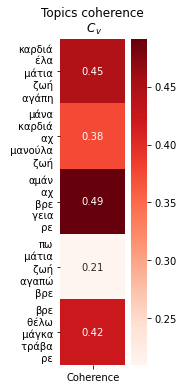

In [13]:
lda_topics = model.show_topics(num_words=5)

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
    topics.append(preprocess_string(topic[1], filters))


#compute coherence measure per topic and visualise it with seaborn
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()

topics_str = [ '\n '.join(t) for t in topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(2,6) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

## Visualise the Topics in a Different Way

/Users/varya/miniforge3/envs/work/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


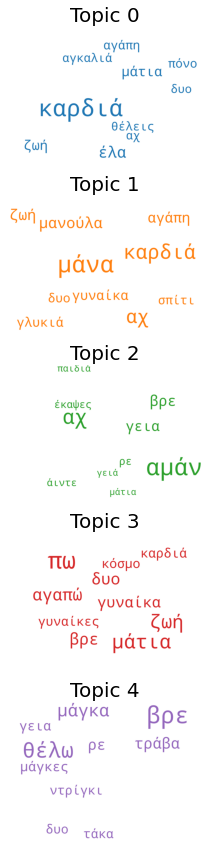

In [14]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')